<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/custom_covid19_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [4]:
for func in [lambda: os.mkdir(os.path.join('.','custom_covid_dataset/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/classic_augment/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/classic_augment/test/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/classic_augment/test/covid')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/classic_augment/test/normal')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/classic_augment/test/pneumonia_bac'))]:
  try:
    func()
  except Exception as error:
    print(error)
    continue

sets=[0,500,1000,2000,3000,4000,5000,7500,10000,15000]

paths=[]

for i in range(len(sets)):
  paths.append('custom_covid_dataset/classic_augment/'+str(sets[i])+'/')
  paths.append('custom_covid_dataset/classic_augment/'+str(sets[i])+'/covid')
  paths.append('custom_covid_dataset/classic_augment/'+str(sets[i])+'/normal')
  paths.append('custom_covid_dataset/classic_augment/'+str(sets[i])+'/pneumonia_bac')

for path in paths:
  try:
    os.mkdir(os.path.join('.', path))
  except Exception as error:
    print(error)
    continue

[Errno 17] File exists: './custom_covid_dataset/'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/test/'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/test/covid'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/test/normal'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/test/pneumonia_bac'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/0/'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/0/covid'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/0/normal'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/0/pneumonia_bac'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/500/'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/500/covid'
[Errno 17] File exists: './custom_covid_dataset/classic_augment/500/normal'
[Errno 17] File exists: './custom_covid_dataset/classic_aug

In [5]:
!git clone https://github.com/vj2050/Transfer-Learning-COVID-19.git

data_dir='Transfer-Learning-COVID-19/dataset_3_classes/'


fatal: destination path 'Transfer-Learning-COVID-19' already exists and is not an empty directory.


In [6]:
img_dim=64
N_rot=3
N_flip=5
N_tran=7
N_scal=3
transform_list=[]

transform_list.append(transforms.Resize((img_dim*2,img_dim*2),interpolation=2))

for i in range(N_rot):
  transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-90,90))], p=0.5))
for i in range(N_flip):
  transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
for i in range(N_flip):
  transform_list.append(transforms.RandomVerticalFlip(p=0.5))
for i in range(N_scal):
  transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,scale=(0.9,1.1))], p=0.5))
for i in range(N_tran):
  transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,translate=(0.1,0.1))], p=0.5))

transform_list.append(transforms.Resize((img_dim,img_dim),interpolation=2))

transform_list.append(transforms.ToTensor())

#transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

transform = transforms.Compose(transform_list)

test_transform = transforms.Compose([transforms.Resize((img_dim,img_dim),interpolation=2),
                                    transforms.ToTensor(),
                                    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

In [7]:
class MyImageFolder(torchvision.datasets.ImageFolder):
  def __getitem__(self, index):
    return super(MyImageFolder, self).__getitem__(index)[0], super(MyImageFolder, self).__getitem__(index)[1], self.imgs[index][0]#return image path

In [8]:
batch_size_train=1
# batch_size_test=27

trainset = MyImageFolder(os.path.join(
          data_dir, "train/"), transform=transform)
trainloader = torch.utils.data.DataLoader(
          trainset, batch_size=batch_size_train, shuffle=True)
# testset = torchvision.datasets.ImageFolder(os.path.join( 
#           data_dir, "test/"), transform=test_transform)
# testloader = torch.utils.data.DataLoader(
#           testset, batch_size=batch_size_test, shuffle=False)
normalset = MyImageFolder(os.path.join(
          data_dir, "test/"), transform=test_transform)
normalloader = torch.utils.data.DataLoader(
          normalset, batch_size=1, shuffle=False)

classes = ("covid", "normal", "pneumonia_bac")

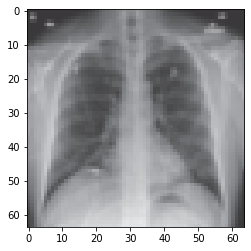

covid


In [9]:
# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(normalloader)
images, labels, path = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size_train)))

name, ext= (path[0].split("/")[-1]).split(".")

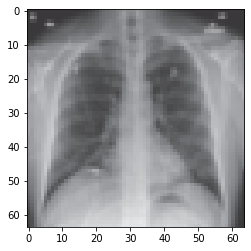

In [10]:
imshow(images[np.random.randint(0,batch_size_train)])

In [14]:
# #MAKE FOLDER 0
# dataiter = iter(normalloader)

# for i in range(len(normalloader.dataset)):
#     images, labels, path = dataiter.next()
   
#     npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))

#     img = Image.fromarray((npimg * 255).astype(np.uint8))

#     name, ext= (path[0].split("/")[-1]).rsplit('.', 1)

#     fold=classes[labels[0]]

#     abs_path='custom_covid_dataset/classic_augment/test/'+fold+'/'+name+'.'+ext
#     # abs_path='custom_covid_dataset/classic_augment/0/'+fold+'/'+name+'.'+ext

#     if ext=='png':
#       img.save(abs_path, 'PNG')
#     else:
#       img.save(abs_path, 'JPEG')

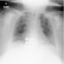

In [ ]:
# dataiter = iter(normalloader)

# images, labels, path = dataiter.next()
   
# npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))

# im = Image.fromarray((npimg * 255).astype(np.uint8))

# display(im)

In [ ]:
dataiter = iter(trainloader)

for i in range(1,len(sets),1):
  covid=sets[i-1] #sequential
  normal=sets[i-1]
  pneu=sets[i-1]
  # covid=0 
  # normal=0
  # pneu=0
  none=1
  print('folder start: ',sets[i])
  dataiter = iter(trainloader)
 
  while covid<sets[i] or normal<sets[i] or pneu<sets[i]:

    images, labels, path = dataiter.next()
   
    npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))

    img = Image.fromarray((npimg * 255).astype(np.uint8))

    name, ext= (path[0].split('/')[-1]).rsplit('.', 1)

    fold=classes[labels[0]]


    if fold == 'covid' and covid<sets[i]:
      abs_path='custom_covid_dataset/classic_augment/'+str(sets[i])+'/'+fold+'/'+str(sets[i])+'.'+str(covid)+'.'+name+'.'+ext
      covid+=1
      if ext=='png':
        img.save(abs_path, 'PNG')
      else:
        img.save(abs_path, 'JPEG')
    else:
      if fold == 'normal' and normal<sets[i]:
        abs_path='custom_covid_dataset/classic_augment/'+str(sets[i])+'/'+fold+'/'+str(sets[i])+'.'+str(normal)+'.'+name+'.'+ext
        normal+=1
        if ext=='png':
          img.save(abs_path, 'PNG')
        else:
          img.save(abs_path, 'JPEG')
      else:
        if fold == 'pneumonia_bac' and pneu<sets[i]:
          abs_path='custom_covid_dataset/classic_augment/'+str(sets[i])+'/'+fold+'/'+str(sets[i])+'.'+str(pneu)+'.'+name+'.'+ext
          pneu+=1
          if ext=='png':
            img.save(abs_path, 'PNG')
          else:
            img.save(abs_path, 'JPEG')
        else:
          none+=1

    if (covid+normal+pneu+none)%200==0:
      dataiter = iter(trainloader)


  print('folder end: ',sets[i])





folder start:  1000
folder end:  1000
folder start:  2000
folder end:  2000
folder start:  3000
